In [0]:
import numpy as np

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [0]:
CUDA = True
BATCH_SIZE = 64

In [0]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
# [CHANGED] Add dropout layer to introduce diversity in gradients
# [CHANGED] [Important] Use LeakyReLU since it keeps gradients better
discriminator = nn.Sequential(
    nn.Dropout(),
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 64),
    nn.Dropout(),
    nn.LeakyReLU(0.2),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

In [0]:
# [CHANGED] [Important] Use LeakyReLU since it keeps noise better
generator = nn.Sequential(
    nn.Linear(128, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 784),
    nn.Sigmoid()
)

In [0]:
if CUDA:
    discriminator.cuda()
    generator.cuda()

In [0]:
LEARNING_RATE_D = 0.0002
LEARNING_RATE_G = 0.0002


opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

In [0]:
N_EPOCH = 100

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3) # set default size of plots

In [0]:
r1 = -1
r2 = 1

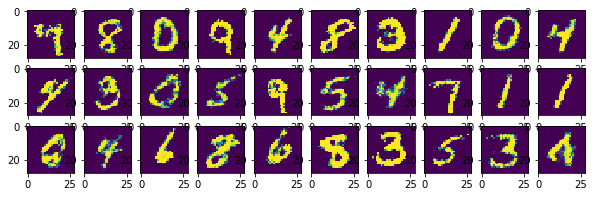

epoch: 26 	 last batch loss D: 1.281423807144165 	 last batch loss G: 0.7833043336868286


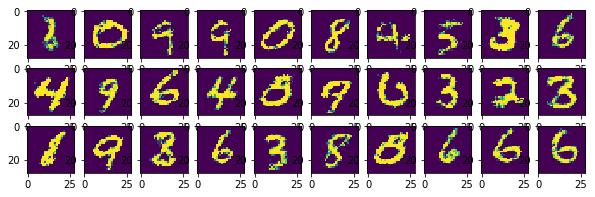

epoch: 27 	 last batch loss D: 1.1676757335662842 	 last batch loss G: 0.8395438194274902


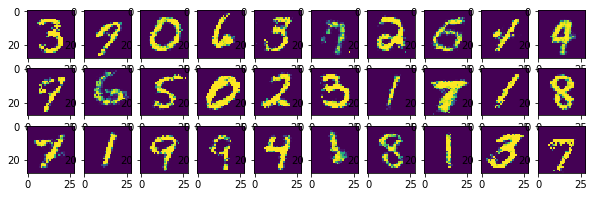

KeyboardInterrupt: ignored

In [32]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        # z = torch.randn(img.shape[0], 128)
        z = (r1 - r2) * torch.rand(img.shape[0], 128)+ r2
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        # z = torch.randn(img.shape[0], 128)
        z = (r1 - r2) * torch.rand(img.shape[0], 128)+ r2
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################

    
    print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

    # [CHANGED] Better output
    for i in range(3):
        for j in range(10):
            plt.subplot(3, 10, i * 10 + j + 1)
            plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
    plt.show()
